# Output Catalog Plots

This notebook reads [simulation output catalogs](http://weaklensingdeblending.readthedocs.org/en/latest/output.html#analysis-results) for different [survey configurations](http://weaklensingdeblending.readthedocs.org/en/latest/src/descwl.survey.html), and makes some summary plots. Plots to summarize the simulation input galaxy catalog are generated in a [separate notebook](http://weaklensingdeblending.readthedocs.org/en/latest/notebooks.html).

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os.path
import astropy.table
import astropy.io.fits as fits

## Read Output Catalogs

In [3]:
output_catalog_path = '..'
def locate(name): return os.path.join(output_catalog_path,'%s.fits' % name)

In [4]:
LSST_i = fits.open(locate('LSST_i_trimmed'))

In [230]:
LSST_r = fits.open(locate('LSST_r_trimmed'))

In [192]:
DES_i = fits.open(locate('DES_i_trimmed'))

In [231]:
DES_r = fits.open(locate('DES_r_trimmed'))

## Signal-to-Noise Estimators

In [374]:
def snr_plot(results,isolation_cut=0.98,detection_cut=6.,save=None):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    # Get our filter band.
    filter = hdr['FILTER_BAND'[-8:]].rstrip()
    # Calculate the simulated area in sq.arcmins.
    area = hdr['IMAGE_WIDTH'[-8:]]*hdr['IMAGE_HEIGHT'[-8:]]*hdr['PIXEL_SCALE'[-8:]]**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    # Only use sources with centroids within the area and snr_iso > 0.
    bad_snr = (cat['snr_iso']<=0.)
    print 'Dropped %d sources with snr_iso = 0 (max. snr_sky = %.3f)' % (
        np.count_nonzero(bad_snr),np.max(cat['snr_sky'][bad_snr]))
    visible = np.logical_and(np.logical_not(bad_snr),cat['visible']>0)
    num_visible = np.count_nonzero(visible)
    print 'Found %d visible sources (%.1f/sq.arcmin.)' % (num_visible,num_visible/area)
    # Calculate median SNR for each estimator.
    for est in ('sky','iso','grp','isof','grpf'):
        print 'Median snr_%s = %.3f' % (est,np.median(cat['snr_'+est][visible]))
    # Define our 'blended' sample.
    blended = np.logical_and(visible,cat['purity'] < isolation_cut)
    num_blended = np.count_nonzero(blended)
    print 'Found %d blended sources (%.1f/sq.arcmin.) with purity < %.3f = %.1f%% of visible sources' % (
        num_blended,num_blended/area,isolation_cut,100.*num_blended/num_visible)
    isolated = np.logical_and(visible,np.logical_not(blended))
    # Prepare labels (we do not call these 'isolated' and 'blended' since we are not requiring that they be detected)
    blended_label = '$\\rho < %.2f$' % isolation_cut
    isolated_label = '$\\rho \geq %.2f$' % isolation_cut
    # Define our 'disk' and 'bulge' samples.
    fcut = 0.1
    disk = np.logical_and(visible,cat['f_bulge']<fcut)
    bulge = np.logical_and(visible,cat['f_bulge']>=fcut)
    print 'Fraction of visible galaxies with f_bulge < %.1f is %.1f%%' % (
        fcut,100.*np.count_nonzero(disk)/num_visible)
    # Initialize figure.
    fig = plt.figure(figsize=(15,8))
    nrow,ncol = 2,3
    # snr_iso vs snr_isof
    plt.subplot(nrow,ncol,1)
    snr_min,snr_max=0.1,1e3
    snr_bins=np.logspace(np.log10(snr_min),np.log10(snr_max),50)
    plt.hist(cat['snr_iso'][visible],bins=snr_bins,histtype='step',color='black',linestyle='dashed',
        weights=area_wgt[visible],label='iso')
    plt.hist(cat['snr_isof'][visible],bins=snr_bins,histtype='step',color='black',
        weights=area_wgt[visible],label='isof')
    plt.hist(cat['snr_isof'][isolated],bins=snr_bins,histtype='stepfilled',color='blue',alpha=0.25,
        weights=area_wgt[isolated],label=isolated_label)
    plt.hist(cat['snr_isof'][blended],bins=snr_bins,histtype='stepfilled',color='red',alpha=0.25,lw=0,
        weights=area_wgt[blended],label=blended_label)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate')
    plt.ylabel('Galaxies / sq.arcmin. / (SNR bin)')
    plt.legend()
    plt.annotate('(a)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # snr_grp vs snr_grpf
    plt.subplot(nrow,ncol,2)
    plt.hist(cat['snr_grp'][visible],bins=snr_bins,histtype='step',color='black',linestyle='dashed',
        weights=area_wgt[visible],label='grp')
    plt.hist(cat['snr_grpf'][visible],bins=snr_bins,histtype='step',color='black',
        weights=area_wgt[visible],label='grpf')
    plt.hist(cat['snr_grpf'][isolated],bins=snr_bins,histtype='stepfilled',color='blue',alpha=0.25,
        weights=area_wgt[isolated],label=isolated_label)
    plt.hist(cat['snr_grpf'][blended],bins=snr_bins,histtype='stepfilled',color='red',alpha=0.25,lw=0,
        weights=area_wgt[blended],label=blended_label)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate')
    plt.ylabel('Galaxies / sq.arcmin. / (SNR bin)')
    plt.legend()
    plt.annotate('(b)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # purity
    plt.subplot(nrow,ncol,3)
    bins = np.linspace(-0.05,1.05,111,endpoint=True)
    plt.hist(cat['purity'][isolated],bins=bins,histtype='stepfilled',color='blue',alpha=0.25,
        weights=area_wgt[isolated],label=isolated_label)
    plt.hist(cat['purity'][blended],bins=bins,histtype='stepfilled',color='red',alpha=0.25,lw=0,
        weights=area_wgt[blended],label=blended_label)
    plt.xlim(bins[0],bins[-1])
    plt.xlabel('Galaxy Purity')
    plt.ylabel('Galaxies / sq.arcmin. / 0.02')
    plt.yscale('log')
    plt.ylim(0,200.)
    plt.legend(loc = 'upper center')
    plt.annotate('(c)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # snr_sky vs snr_iso
    plt.subplot(nrow,ncol,4)
    plt.scatter(cat['snr_iso'][visible],cat['snr_iso'][visible]/cat['snr_sky'][visible],
        c=cat['ab_mag'][visible],s=8,lw=0,vmin=21.,rasterized=True)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate $\\nu_{iso}$')
    plt.ylabel('Signal-to-noise degradation $\\nu_{iso}/\\nu_{sky}$')
    plt.xlim(snr_min,snr_max)
    plt.ylim(0.90,1.01)
    plt.colorbar(label='$%s_{AB}$ magnitude' % filter,pad=0.01)
    plt.annotate('(d)',xy=(0.1,0.8),xycoords='axes fraction',fontsize='large')
    # snr_iso vs snr_isof
    plt.subplot(nrow,ncol,5)
    w=disk
    z=cat['sigma_m'][w]
    zmin,zmax = np.percentile(z,(10.,90.))
    plt.scatter(cat['snr_iso'][w],cat['snr_isof'][w]/cat['snr_iso'][w],
        c=z,vmin=zmin,vmax=zmax,s=8,lw=0,rasterized=True)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate $\\nu_{iso}$')
    plt.ylabel('Signal-to-noise degradation $\\nu_{isof}/\\nu_{iso}$')
    plt.xlim(snr_min,snr_max)
    plt.ylim(0.0,0.8)
    plt.colorbar(label='Galaxy size $\sigma_{-}$ (arcseconds)',pad=0.01)
    plt.annotate('(e)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    # snr_grpf vs purity
    plt.subplot(nrow,ncol,6)
    w=visible
    z=cat['snr_grpf'][w]/cat['snr_iso'][w]
    zmin,zmax = np.percentile(z,(10.,90.))
    plt.scatter(cat['snr_grpf'][w],cat['purity'][w],
        c=z,vmin=zmin,vmax=zmax,s=8,lw=0,rasterized=True)
    plt.xscale('log')
    plt.xlabel('Signal-to-noise estimate $\\nu_{grpf}$')
    plt.ylabel('Purity $\\rho$')
    plt.xlim(snr_min,snr_max)
    plt.ylim(-0.05,1.05)
    plt.colorbar(label='SNR degradation $\\nu_{grpf}/\\nu_{iso}$',pad=0.01)
    plt.annotate('',xy=(snr_min,isolation_cut),xytext=(snr_max,isolation_cut),xycoords='data',textcoords='data',
        arrowprops={'arrowstyle':'-','color':'black','linewidth':3,'linestyle':'dashed'})
    if detection_cut is not None:
        plt.annotate('',xy=(detection_cut,-0.05),xytext=(detection_cut,1.05),xycoords='data',textcoords='data',
            arrowprops={'arrowstyle':'-','color':'black','linewidth':3,'linestyle':'dashed'})
    plt.annotate('(f)',xy=(0.9,0.1),xycoords='axes fraction',fontsize='large')
    #
    plt.tight_layout();
    if save is not None:
        plt.savefig(save+'.pdf')
        plt.savefig(save+'.png')

Simulated area = 186.414 sq.arcmins.
Dropped 9 sources with snr_iso = 0 (max. snr_sky = 0.130)
Found 44984 visible sources (241.3/sq.arcmin.)
Median snr_sky = 5.012
Median snr_iso = 5.008
Median snr_grp = 4.987
Median snr_isof = 3.206
Median snr_grpf = 2.325
Found 25813 blended sources (138.5/sq.arcmin.) with purity < 0.980 = 57.4% of visible sources
Fraction of visible galaxies with f_bulge < 0.1 is 89.3%


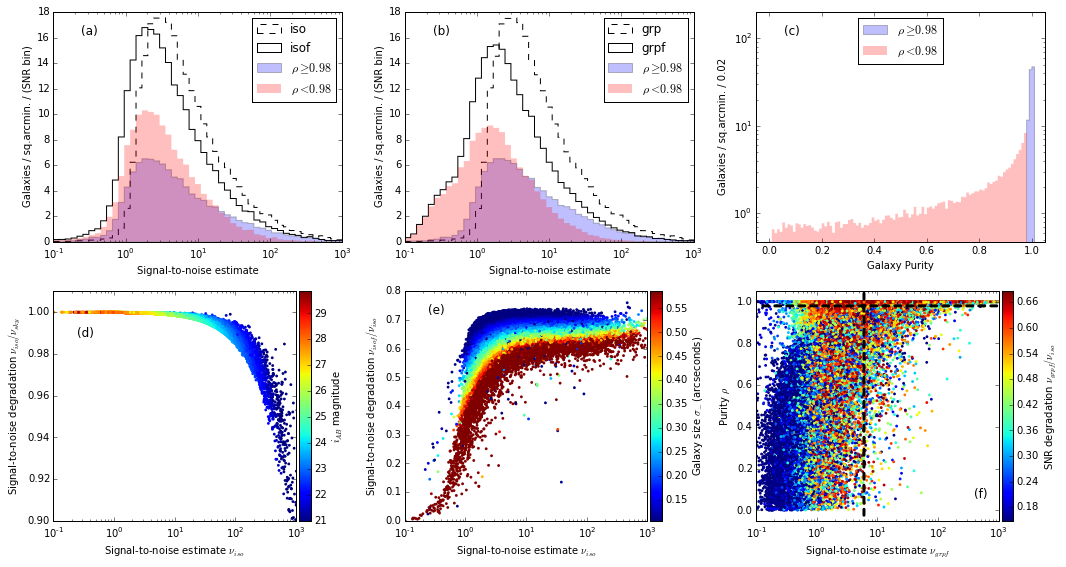

In [375]:
snr_plot(LSST_i,save='output/snr_plots')

Simulated area = 186.434 sq.arcmins.
Dropped 302 sources with snr_iso = 0 (max. snr_sky = 0.165)
Found 44094 visible sources (236.5/sq.arcmin.)
Median snr_sky = 0.976
Median snr_iso = 0.975
Median snr_grp = 0.963
Median snr_isof = 0.519
Median snr_grpf = 0.395
Found 20605 blended sources (110.5/sq.arcmin.) with purity < 0.980 = 46.7% of visible sources
Fraction of visible galaxies with f_bulge < 0.1 is 89.1%


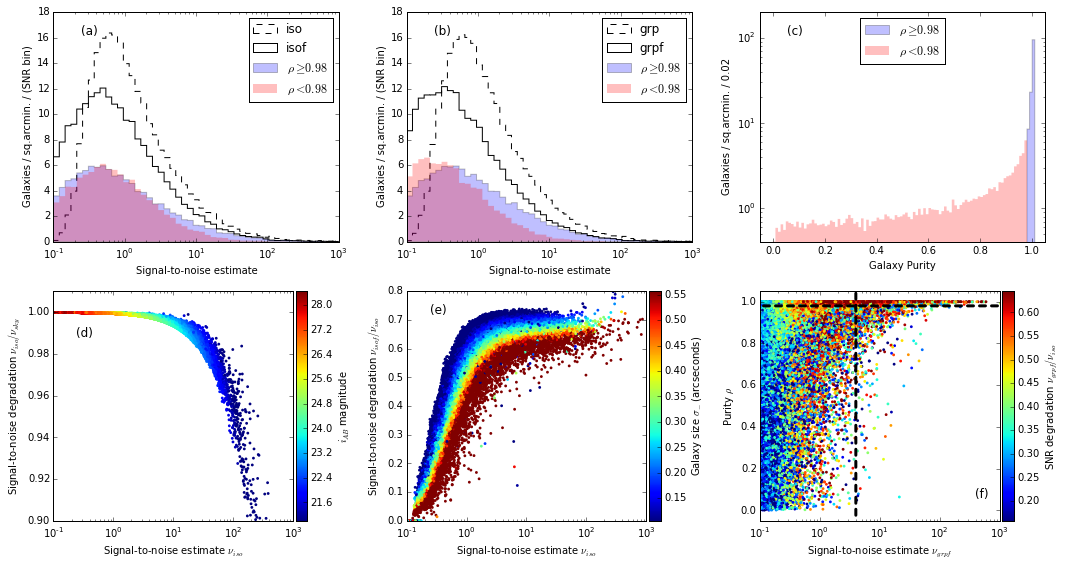

In [376]:
snr_plot(DES_i,detection_cut=4.)

## Samples

In [5]:
def make_samples(cat,isolation_cut,detection_cut):
    # Only use sources with centroids within the area and snr_iso > 0.
    bad_snr = (cat['snr_iso']<=0.)
    num_bad = np.count_nonzero(bad_snr)
    if num_bad > 0:
        print 'Dropped %d sources with snr_iso = 0 (max. snr_sky = %.3f)' % (
            num_bad,np.max(cat['snr_sky'][bad_snr]))
    visible = np.logical_and(np.logical_not(bad_snr),cat['visible']>0)
    num_visible = np.count_nonzero(visible)
    # Undetected sources are visible but fail the detection cut.
    undetected = np.logical_and(visible,cat['snr_grpf']<detection_cut)
    num_undetected = np.count_nonzero(undetected)
    detected = np.logical_and(visible,cat['snr_grpf']>=detection_cut)
    num_detected = np.count_nonzero(detected)
    # Blended sources are visible, detected, and fail the purity cut.
    blended = np.logical_and(detected,cat['purity']<isolation_cut)
    num_blended = np.count_nonzero(blended)
    # Isolated sources are visible, detected, and pass the purity cut.
    isolated = np.logical_and(detected,cat['purity']>=isolation_cut)
    num_isolated = np.count_nonzero(isolated)
    # Print summary statistics.
    print 'Visible sample fractions: undetected %.2f%%, blended %.2f%%, isolated %.2f%%' % (
        100.*num_undetected/num_visible,100.*num_blended/num_visible,100.*num_isolated/num_visible)
    print 'Detected sample fractions: blended %.2f%%, isolated %.2f%%' % (
        100.*num_blended/num_detected,100.*num_isolated/num_detected)
    return undetected,detected,blended,isolated

In [378]:
def samples_plot(results,isolation_cut=0.98,detection_cut=6.,save=None):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    # Get our filter band.
    filter = hdr['FILTER_BAND'[-8:]].rstrip()
    # Calculate the simulated area in sq.arcmins.
    area = hdr['IMAGE_WIDTH'[-8:]]*hdr['IMAGE_HEIGHT'[-8:]]*hdr['PIXEL_SCALE'[-8:]]**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    # Get our samples.
    undetected,detected,blended,isolated = make_samples(cat,isolation_cut,detection_cut)
    # Initialize figure.
    fig = plt.figure(figsize=(12,8))
    nrow,ncol = 2,3
    # redshift
    plt.subplot(nrow,ncol,1)
    zmax=5.
    nbins=25
    plt.hist(cat['z'][detected],bins=nbins,range=(0,zmax),histtype='step',color='black',
             weights=area_wgt[detected],label='Detected')
    plt.hist(cat['z'][isolated],bins=nbins,range=(0,zmax),histtype='step',color='blue',ls='dashed',
             weights=area_wgt[isolated],label='Isolated')
    plt.hist(cat['z'][blended],bins=nbins,range=(0,zmax),histtype='stepfilled',color='red',alpha=0.5,
             weights=area_wgt[blended],label='Blended')
    plt.xlabel('Catalog redshift')
    plt.ylabel('Galaxies / sq.arcmin. / ($\Delta z = %.1f$)' % (zmax/nbins))
    plt.annotate('(a)',xy=(0.4,0.9),xycoords='axes fraction',fontsize='large')
    plt.legend()
    # size
    plt.subplot(nrow,ncol,2)
    rmax=1.5
    nbins=30
    plt.hist(cat['sigma_m'][detected],bins=nbins,range=(0,rmax),histtype='step',color='black',
             weights=area_wgt[detected],label='Detected')
    plt.hist(cat['sigma_m'][isolated],bins=nbins,range=(0,rmax),histtype='step',color='blue',ls='dashed',
             weights=area_wgt[isolated],label='Isolated')
    plt.hist(cat['sigma_m'][blended],bins=nbins,range=(0,rmax),histtype='stepfilled',color='red',alpha=0.5,
             weights=area_wgt[blended],label='Blended')
    plt.xlim(0.,rmax)
    plt.xlabel('Catalog size $\sigma_{-} = |Q|^{1/4}$ (arcsec.)')
    plt.ylabel('Galaxies / sq. arcmin. / ($\Delta\sigma_{-}=%.1f$)' % (rmax/nbins))
    plt.annotate('(b)',xy=(0.4,0.9),xycoords='axes fraction',fontsize='large')
    plt.legend()
    # bulge fraction
    plt.subplot(nrow,ncol,3)
    nbins=29
    plt.hist(cat['f_bulge'][detected],bins=nbins,range=(-0.06,1.06),histtype='step',color='black',
             weights=area_wgt[detected],label='Detected')
    plt.hist(cat['f_bulge'][isolated],bins=nbins,range=(-0.06,1.06),histtype='step',color='blue',ls='dashed',
             weights=area_wgt[isolated],label='Isolated')
    plt.hist(cat['f_bulge'][blended],bins=nbins,range=(-0.06,1.06),histtype='stepfilled',color='red',alpha=0.5,
             weights=area_wgt[blended],label='Blended')
    plt.yscale('log')
    plt.xlim(-0.06,1.06)
    plt.ylim(1e-2,8e1)
    plt.xlabel('Bulge-to-total flux fraction')
    plt.ylabel('Galaxies / sq.armin. / %.2f' % (1./nbins))
    plt.annotate('(c)',xy=(0.4,0.9),xycoords='axes fraction',fontsize='large')
    plt.legend()
    # ellipticity magnitude
    plt.subplot(nrow,ncol,4)
    emag = np.sqrt(cat['e1']**2+cat['e2']**2)
    emax=0.68
    nbins=17
    plt.hist(emag[detected],bins=nbins,range=(0,emax),histtype='step',color='black',
        weights=area_wgt[detected],label='Detected')
    plt.hist(emag[isolated],bins=nbins,range=(0,emax),histtype='step',color='blue',ls='dashed',
        weights=area_wgt[isolated],label='Isolated')
    plt.hist(emag[blended],bins=nbins,range=(0,emax),histtype='stepfilled',color='red',alpha=0.5,
        weights=area_wgt[blended],label='Blended')
    plt.xlim(0,emax)
    plt.xlabel('Catalog ellipticity magnitude $|\epsilon|$')
    plt.ylabel('Galaxies / sq.arcmin. / ($\Delta\epsilon=%.2f$)' % (emax/nbins))
    plt.annotate('(d)',xy=(0.4,0.9),xycoords='axes fraction',fontsize='large')
    plt.legend()
    #
    plt.subplot(nrow,ncol,5)
    abmin,abmax=20.,27.
    nbins=14
    plt.hist(cat['ab_mag'][detected],bins=nbins,range=(abmin,abmax),histtype='step',color='black',
        weights=area_wgt[detected],label='Detected')
    plt.hist(cat['ab_mag'][isolated],bins=nbins,range=(abmin,abmax),histtype='step',color='blue',ls='dashed',
        weights=area_wgt[isolated],label='Isolated')
    plt.hist(cat['ab_mag'][blended],bins=nbins,range=(abmin,abmax),histtype='stepfilled',color='red',alpha=0.5,
        weights=area_wgt[blended],label='Blended')
    plt.ylim(0.,12.)
    plt.xlabel('Catalog $%s_{AB}$ magnitude' % filter)
    plt.ylabel('Galaxies / sq.arcmin. / (%.1f mag)' % ((abmax-abmin)/nbins))
    plt.annotate('(e)',xy=(0.85,0.9),xycoords='axes fraction',fontsize='large')
    plt.legend(loc='upper left')
    #
    plt.subplot(nrow,ncol,6)
    rimin,rimax = -0.6,+1.8
    nbins=12
    plt.hist(cat['ri_color'][detected],bins=nbins,range=(rimin,rimax),histtype='step',color='black',
        weights=area_wgt[detected],label='Detected')
    plt.hist(cat['ri_color'][isolated],bins=nbins,range=(rimin,rimax),histtype='step',color='blue',ls='dashed',
        weights=area_wgt[isolated],label='Isolated')
    plt.hist(cat['ri_color'][blended],bins=nbins,range=(rimin,rimax),histtype='stepfilled',color='red',alpha=0.5,
        weights=area_wgt[blended],label='Blended')
    plt.xlabel('Catalog color $(r-i)_{AB}$')
    plt.ylabel('Galaxies / sq.arcmin. / (%.1f mag)' % ((rimax-rimin)/nbins))
    plt.annotate('(f)',xy=(0.1,0.9),xycoords='axes fraction',fontsize='large')
    plt.legend()
    #
    plt.tight_layout();
    if save is not None:
        plt.savefig(save+'.pdf')
        plt.savefig(save+'.png')

Simulated area = 186.414 sq.arcmins.
Dropped 9 sources with snr_iso = 0 (max. snr_sky = 0.130)
Visible sample fractions: undetected 74.94%, blended 8.91%, isolated 16.15%
Detected sample fractions: blended 35.57%, isolated 64.43%


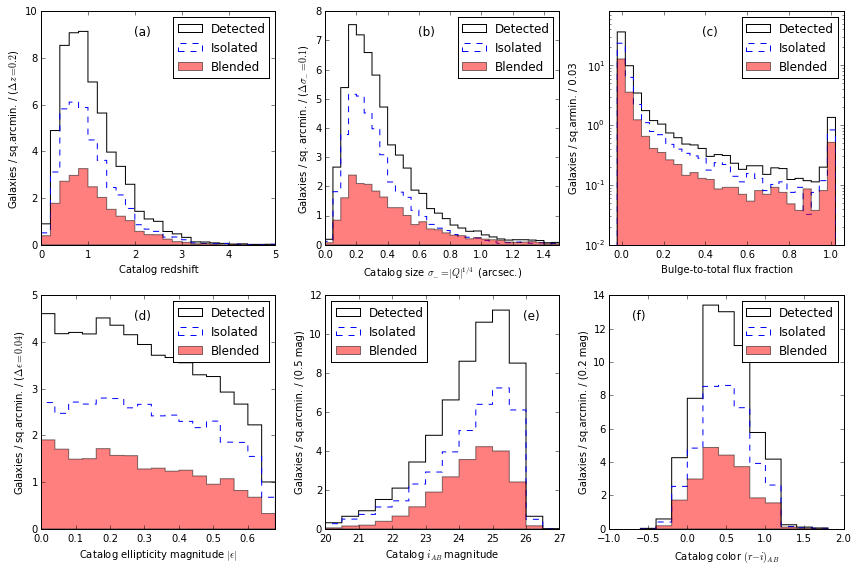

In [379]:
samples_plot(LSST_i,save='output/samples')

Simulated area = 186.434 sq.arcmins.
Dropped 302 sources with snr_iso = 0 (max. snr_sky = 0.165)
Visible sample fractions: undetected 93.72%, blended 1.15%, isolated 5.13%
Detected sample fractions: blended 18.34%, isolated 81.66%


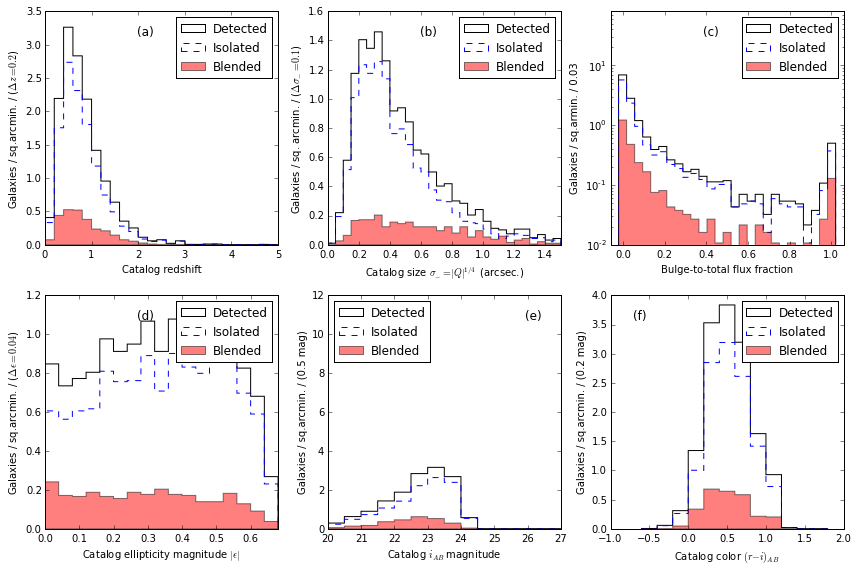

In [380]:
samples_plot(DES_i)

## Shear Estimation

In [16]:
def shear_plot(results,isolation_cut=0.98,detection_cut=6.,save=None):
    hdr = results[0].header
    cat = astropy.table.Table.read(results,hdu=1)
    # Get our filter band.
    filter = hdr['FILTER_BAND'[-8:]].rstrip()
    # Calculate the simulated area in sq.arcmins.
    area = hdr['IMAGE_WIDTH'[-8:]]*hdr['IMAGE_HEIGHT'[-8:]]*hdr['PIXEL_SCALE'[-8:]]**2/3600.
    print 'Simulated area = %.3f sq.arcmins.' % area
    area_wgt = np.empty_like(cat['snr_sky'])
    area_wgt[:] = 1/area
    # Only use sources with centroids within the area and snr_iso > 0.
    bad_snr = (cat['snr_iso']<=0.)
    print 'Dropped %d sources with snr_iso = 0 (max. snr_sky = %.3f)' % (
        np.count_nonzero(bad_snr),np.max(cat['snr_sky'][bad_snr]))
    # Get our samples.
    undetected,detected,blended,isolated = make_samples(cat,isolation_cut,detection_cut)
    # Calculate the intrinsic shape noise variance of detected objects.
    intrinsic_var = 0.5*(np.var(cat['e1'][detected]) + np.var(cat['e2'][detected]))
    print 'Detected intrinsic shape-noise RMS = %.3f' % np.sqrt(intrinsic_var)
    # Calculate neff weights per object.
    wgt = 0.5*(intrinsic_var/(intrinsic_var+cat['dg1']**2)+intrinsic_var/(intrinsic_var+cat['dg2']**2))
    # Calculate |e| values per object.
    emag = np.sqrt(cat['e1']**2+cat['e2']**2)
    # Summary statistics.
    num_detected = np.count_nonzero(detected)
    for name in ('detected','isolated','blended'):
        sample = eval(name)
        num_sample = np.count_nonzero(sample)
        Neff = np.sum(wgt[sample])/area
        var_e = 0.5*(np.var(cat['e1'][sample])+np.var(cat['e2'][sample]))
        zavg = np.sum(wgt[sample]*cat['z'][sample])/np.sum(wgt[sample])
        print '%10s sample is %5.1f%% of detected with neff/area = %6.3f, RMS e = %6.4f, <z> = %.3f' % (
            name,100.*num_sample/num_detected,Neff,np.sqrt(var_e),zavg)
    # Define a generic plotting method.
    def make_plot(figlabel,what,nbins,rng,xlabel,binformat,loc='upper right',logx=False,logy=False,accumdir=None):
        if logx:
            bins=np.logspace(np.log10(rng[0]),np.log10(rng[1]),nbins+1,endpoint=True)
        else:
            bins=np.linspace(rng[0],rng[1],nbins+1,endpoint=True)
        plt.hist(what[detected],weights=area_wgt[detected],
                 color='black',histtype='step',ls='dotted',label='Unweighted',bins=bins)
        if logx:
            plt.xscale('log')
        plt.xlim(*rng)
        if logy:
            plt.yscale('log')
            ymin,ymax = plt.gca().get_ylim()
            plt.ylim(1e-4*ymax,ymax) # always show 4 decades
        plt.gca().autoscale(False)
        plt.hist(what[detected],weights=area_wgt[detected]*wgt[detected],
                 color='blue',alpha=0.25,histtype='stepfilled',label='Isolated',bins=bins)
        plt.hist(what[blended],weights=area_wgt[blended]*wgt[blended],
                 facecolor='red',lw=0,histtype='stepfilled',label='Blended',bins=bins)
        plt.xlabel(xlabel)
        try:
            binlabel = binformat % ((rng[1]-rng[0])/nbins)
        except TypeError:
            binlabel = binformat # ok if format does not need any interpolation
        plt.ylabel('Galaxies / sq.arcmin. / (%s)' % binlabel)
        plt.annotate(figlabel,xy=(0.5,0.9),xycoords='axes fraction',fontsize='large',horizontalalignment='center')
        plt.legend(loc = loc)
        if accumdir in ('up','down'):
            detected_accum = accumulate(what,bins,detected,area_wgt*wgt,accumdir)
            isolated_accum = accumulate(what,bins,isolated,area_wgt*wgt,accumdir)
            return bins,detected_accum,isolated_accum
            
    def accumulate(what,bins,sample,weights,direction):
        bincounts,binedges = np.histogram(what[sample],bins=bins,weights=weights[sample])
        assert np.array_equal(bins,binedges)
        cummulative = np.zeros_like(bins)
        if direction == 'up':
            cummulative[1:] = np.cumsum(bincounts)
            underflow = (what[sample] <= bins[0])
            cummulative += np.sum(weights[sample][underflow])
        elif direction == 'down':
            cummulative[:-1] = np.cumsum(bincounts[::-1])[::-1]
            overflow = (what[sample] > bins[-1])
            cummulative += np.sum(weights[sample][overflow])
        else:
            raise RuntimeError('invalid direction "%s".' % direction)
        return cummulative
    
    # Initialize figure.
    fig = plt.figure(figsize=(15,15))
    nrow,ncol = 3,3
    #
    plt.subplot(nrow,ncol,1)
    make_plot('(a)',cat['z'],20,(0.,4.),'Catalog redshift $z$','$\Delta z=%.2f$')
    #
    plt.subplot(nrow,ncol,2)
    x,y1,y2 = make_plot('(b)',cat['ab_mag'],28,(20.,27.),'Catalog magnitude $%s_{AB}$' % filter,'%.1f mag',
        loc='upper left',accumdir='up')
    #
    plt.subplot(nrow,ncol,3)
    plt.plot(x,y1,'k-',label='Detected')
    plt.plot(x,y2,'b-',label='Isolated')
    plt.plot(x,y1-y2,'r-',label='Blended')
    plt.xlim(x[0],x[-1])
    plt.xlabel('Maximum magnitude $%s_{AB}$' % filter)
    plt.ylabel('Integrated $N_{eff}$ (Galaxies / sq.arcmin.)')
    plt.annotate('(c)',xy=(0.5,0.9),xycoords='axes fraction',fontsize='large',horizontalalignment='center')
    plt.legend(loc='upper left')
    #
    plt.subplot(nrow,ncol,4)
    make_plot('(d)',emag,17,(0.,0.68),'Catalog ellipticity magnitude $|\epsilon|$','$\Delta\epsilon=%.2f$')
    #
    plt.subplot(nrow,ncol,5)
    x,y1,y2 = make_plot('(e)',cat['sigma_m'],30,(0.,1.5),'Catalog size $\sigma_{-} = |Q|^{1/4}$ (arcsec.)',
        '$\Delta\sigma_{-}=%.1f$',accumdir='down')
    #
    plt.subplot(nrow,ncol,6)
    plt.plot(x,y1,'k-',label='Detected')
    plt.plot(x,y2,'b-',label='Isolated')
    plt.plot(x,y1-y2,'r-',label='Blended')
    plt.xlim(x[0],x[-1])
    plt.xlabel('Minimum catalog size $\sigma_{-}$ (arcsec.)')
    plt.ylabel('Integrated $N_{eff}$ (Galaxies / sq.arcmin.)')
    plt.annotate('(f)',xy=(0.5,0.9),xycoords='axes fraction',fontsize='large',horizontalalignment='center')
    plt.legend()
    #
    plt.subplot(nrow,ncol,7)
    ##make_plot('(g)',cat['f_bulge'],29,(-0.06,1.06),'Bulge-to-total flux fraction','$%.2f$',logy=True)
    ##make_plot('(g)',cat['beta'],20,(-0.5*np.pi,0.5*np.pi),'Unsheared Position Angle $\\beta$ (rad)','$\Delta\\beta=%.3f$')
    make_plot('(g)',cat['ri_color'],24,(-0.6,+1.8),'Catalog color $(r-i)_{AB}$','%.1f mag')
    #
    plt.subplot(nrow,ncol,8)
    x,y1,y2 = make_plot('(h)',cat['snr_grpf'],40,(detection_cut,200*detection_cut),
        'Signal-to-noise ratio $\\nu_{grpf}$','SNR bin',logx=True,accumdir='down')
    #
    plt.subplot(nrow,ncol,9)
    plt.plot(x,y1,'k-',label='Detected')
    plt.plot(x,y2,'b-',label='Isolated')
    plt.plot(x,y1-y2,'r-',label='Blended')
    plt.xlim(x[0],x[-1])
    plt.ylim(0,None)
    plt.xscale('log')
    plt.xlabel('Minimum signal-to-noise ratio $\\nu_{grpf}$')
    plt.ylabel('Integrated $N_{eff}$ (Galaxies / sq.arcmin.)')
    plt.annotate('(i)',xy=(0.5,0.9),xycoords='axes fraction',fontsize='large',horizontalalignment='center')
    plt.legend()
    #
    plt.tight_layout();
    if save is not None:
        plt.savefig(save+'.pdf')
        plt.savefig(save+'.png')

Simulated area = 186.414 sq.arcmins.
Dropped 9 sources with snr_iso = 0 (max. snr_sky = 0.130)
Dropped 9 sources with snr_iso = 0 (max. snr_sky = 0.130)
Visible sample fractions: undetected 74.94%, blended 8.91%, isolated 16.15%
Detected sample fractions: blended 35.57%, isolated 64.43%
Detected intrinsic shape-noise RMS = 0.245
  detected sample is 100.0% of detected with neff/area = 39.646, RMS e = 0.2451, <z> = 1.052
  isolated sample is  64.4% of detected with neff/area = 25.020, RMS e = 0.2495, <z> = 1.023
   blended sample is  35.6% of detected with neff/area = 14.626, RMS e = 0.2371, <z> = 1.100


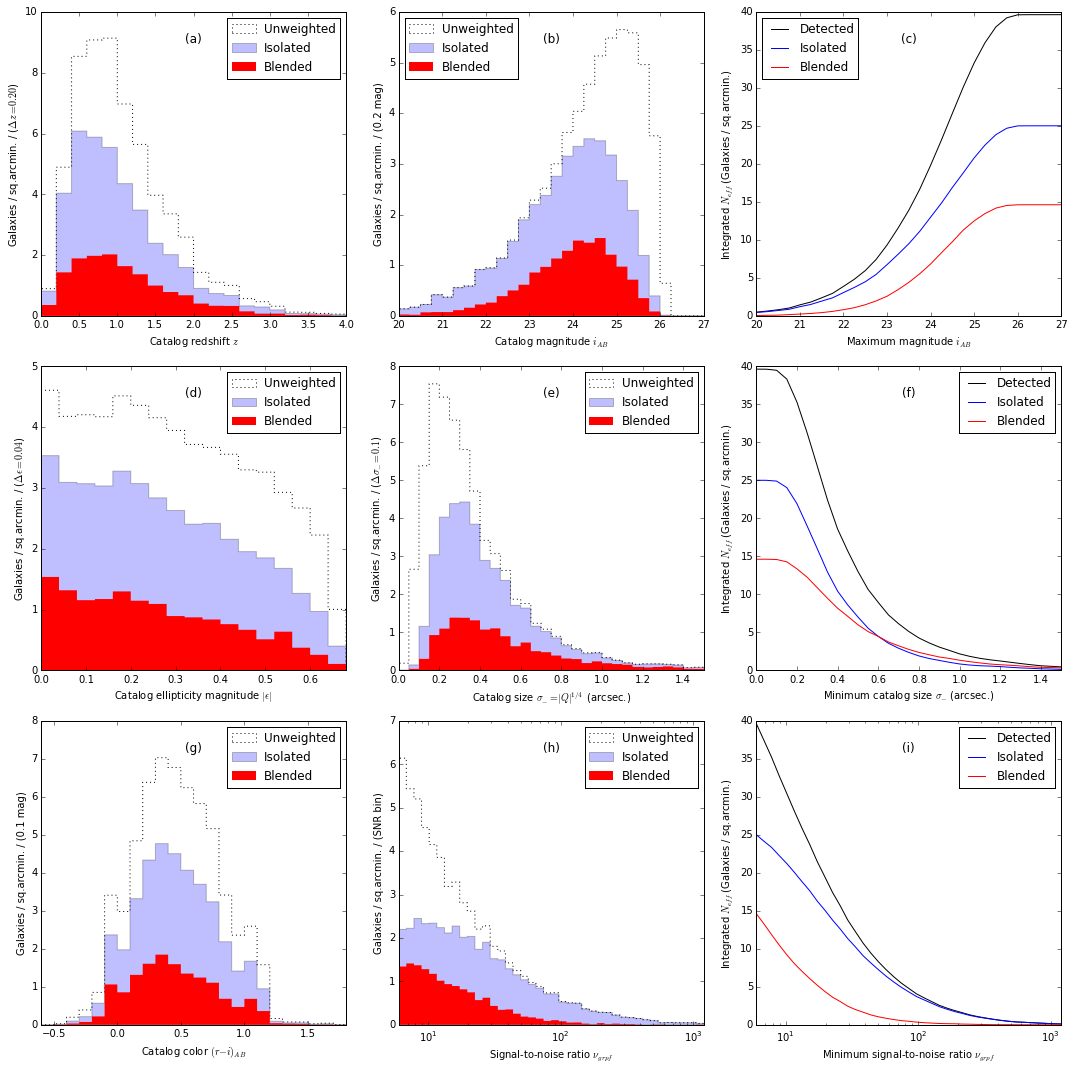

In [17]:
shear_plot(LSST_i,save='output/LSST_i')

Simulated area = 186.414 sq.arcmins.
Dropped 2 sources with snr_iso = 0 (max. snr_sky = 0.094)
Dropped 2 sources with snr_iso = 0 (max. snr_sky = 0.094)
Visible sample fractions: undetected 67.03%, blended 13.84%, isolated 19.13%
Detected sample fractions: blended 41.98%, isolated 58.02%
Detected intrinsic shape-noise RMS = 0.239
  detected sample is 100.0% of detected with neff/area = 50.027, RMS e = 0.2395, <z> = 1.216
  isolated sample is  58.0% of detected with neff/area = 28.405, RMS e = 0.2447, <z> = 1.180
   blended sample is  42.0% of detected with neff/area = 21.622, RMS e = 0.2320, <z> = 1.262


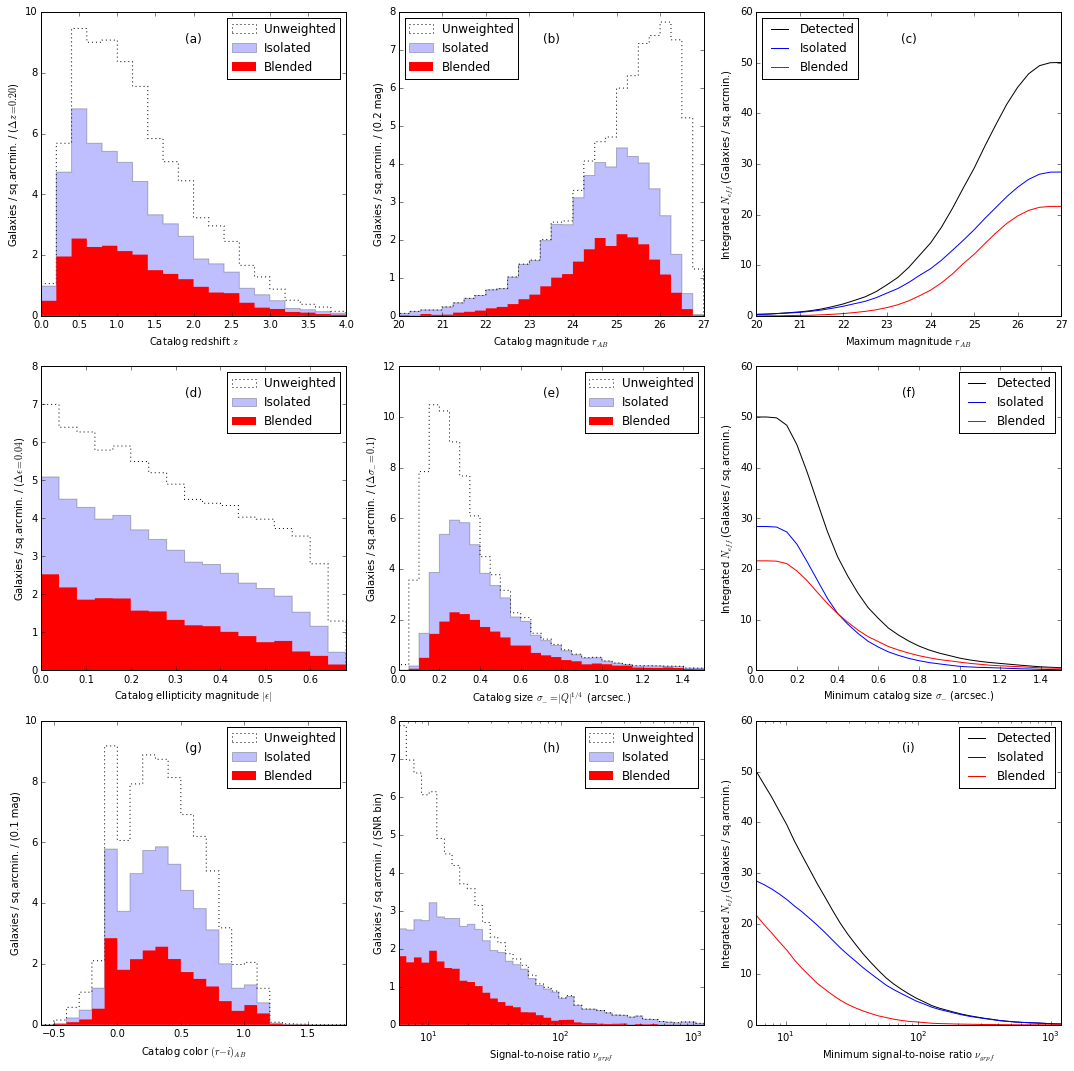

In [385]:
shear_plot(LSST_r,save='output/LSST_r')

Simulated area = 186.434 sq.arcmins.
Dropped 302 sources with snr_iso = 0 (max. snr_sky = 0.165)
Dropped 302 sources with snr_iso = 0 (max. snr_sky = 0.165)
Visible sample fractions: undetected 93.72%, blended 1.15%, isolated 5.13%
Detected sample fractions: blended 18.34%, isolated 81.66%
Detected intrinsic shape-noise RMS = 0.267
  detected sample is 100.0% of detected with neff/area =  9.893, RMS e = 0.2669, <z> = 0.799
  isolated sample is  81.7% of detected with neff/area =  7.826, RMS e = 0.2706, <z> = 0.791
   blended sample is  18.3% of detected with neff/area =  2.067, RMS e = 0.2499, <z> = 0.828


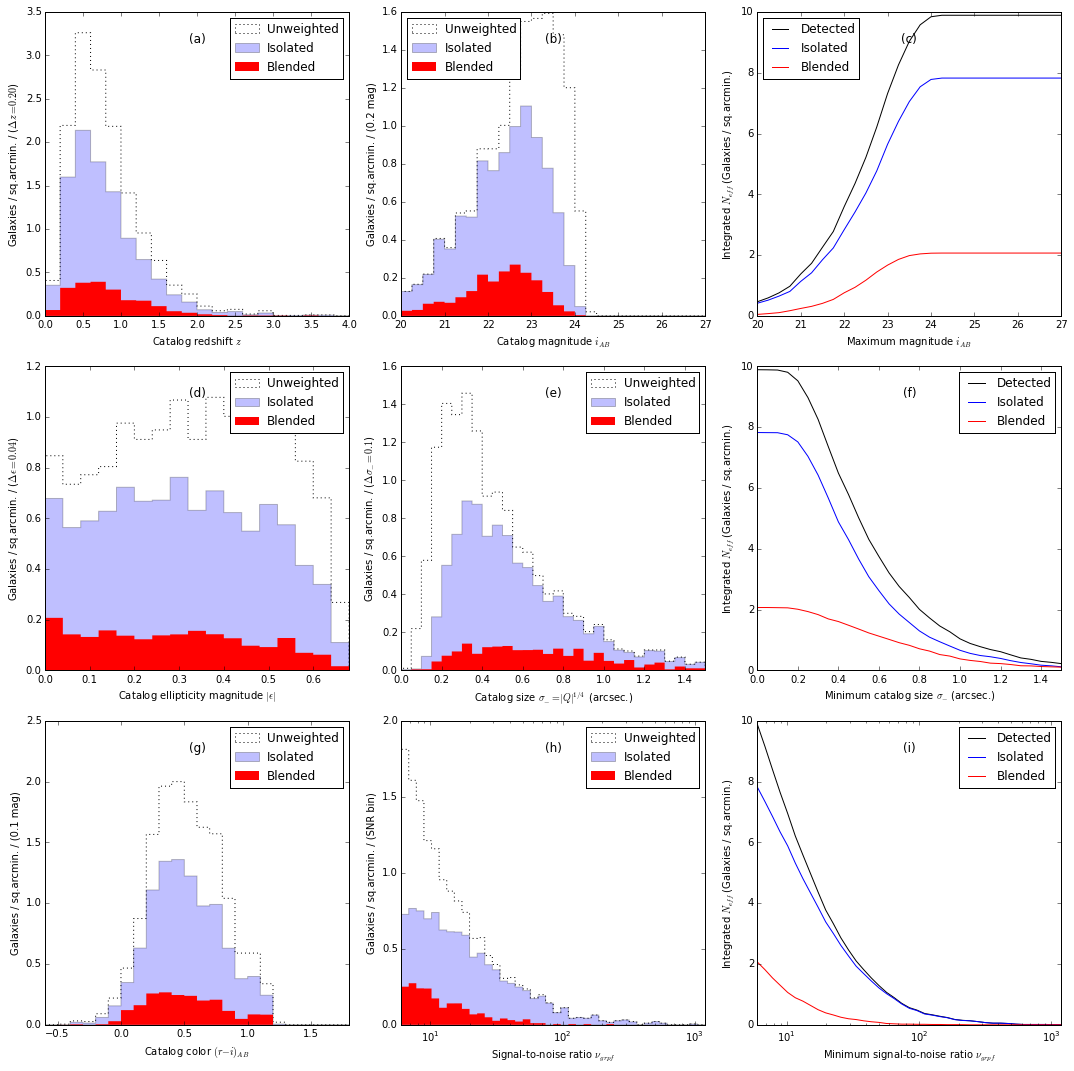

In [386]:
shear_plot(DES_i,save='output/DES_i')

Simulated area = 186.434 sq.arcmins.
Dropped 86 sources with snr_iso = 0 (max. snr_sky = 0.161)
Dropped 86 sources with snr_iso = 0 (max. snr_sky = 0.161)
Visible sample fractions: undetected 93.45%, blended 1.28%, isolated 5.27%
Detected sample fractions: blended 19.55%, isolated 80.45%
Detected intrinsic shape-noise RMS = 0.265
  detected sample is 100.0% of detected with neff/area = 10.606, RMS e = 0.2647, <z> = 0.891
  isolated sample is  80.5% of detected with neff/area =  8.292, RMS e = 0.2684, <z> = 0.885
   blended sample is  19.5% of detected with neff/area =  2.315, RMS e = 0.2488, <z> = 0.912


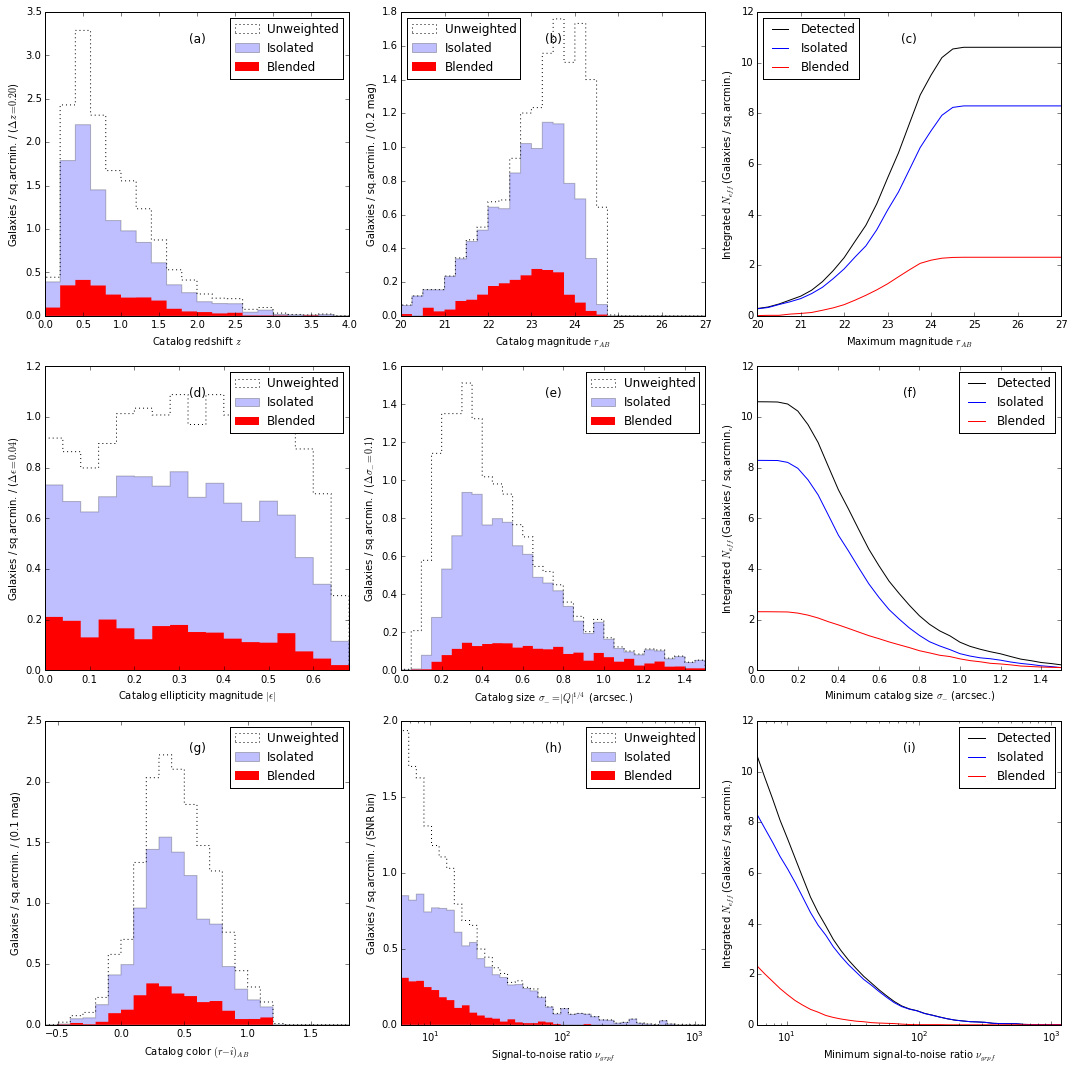

In [387]:
shear_plot(DES_r,save='output/DES_r')